In [1]:
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import tensorflow as tf

from collections import defaultdict, Counter
from PIL import Image
from tqdm import tqdm

In [2]:
sys.path.append('../../steel/')
from deeplab.utils import image_utils
from deeplab import input_preprocess

In [3]:
DATA_DIR = '../../data/'

# If the repo / data is organize correctly this shoult exists
assert os.path.exists(DATA_DIR)

In [4]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 1600
IMAGE_CHANNELS = 3

# Load data

In [5]:
train_image_files = glob.glob(os.path.join(DATA_DIR, 'train_images', '*.jpg'))
test_image_files = glob.glob(os.path.join(DATA_DIR, 'test_images', '*.jpg'))
print("{} images in the train set !".format(len(train_image_files)))
print("{} images in the test set !".format(len(test_image_files)))

12568 images in the train set !
1801 images in the test set !


In [9]:
# train_image_files[0]

In [10]:
train_labels_file = os.path.join(DATA_DIR, 'train.csv')
train_df = pd.read_csv(train_labels_file)

print(train_df.shape)
train_df.head()

(50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [11]:
image_id_to_file = {f.split('/')[-1].split('.')[0]: f for f in train_image_files}
image_ids = list(image_id_to_file.keys())

In [12]:
image_id_class_id_to_mask = dict(zip(train_df.ImageId_ClassId, train_df.EncodedPixels))
image_id_to_masks = {image_id : [image_id_class_id_to_mask['{}.jpg_{}'.format(image_id, i+1)] for i in range(4)] 
                     for image_id in image_ids}

# Visualize 

### Utility functions

In [13]:
def masks_to_mask(mask_list):
    assert len(mask_list) == 4, "The list of masks should be of length 4."
    mask = np.zeros(mask_list[0].shape[:2], np.uint8)
    
    for i in range(4):
        mask += (i + 1) * mask_list[i]

    return mask

### Plot

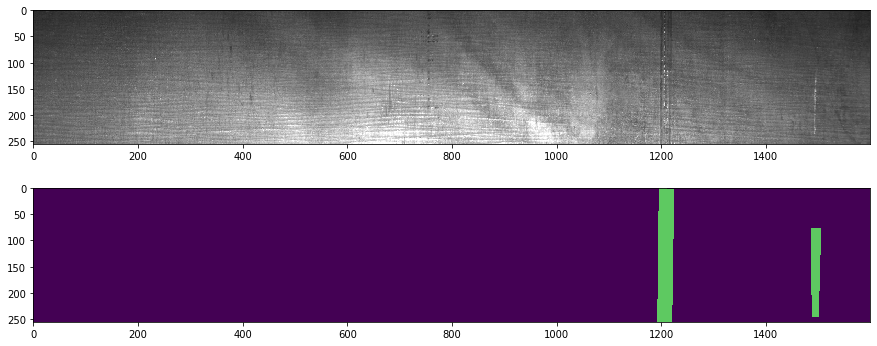

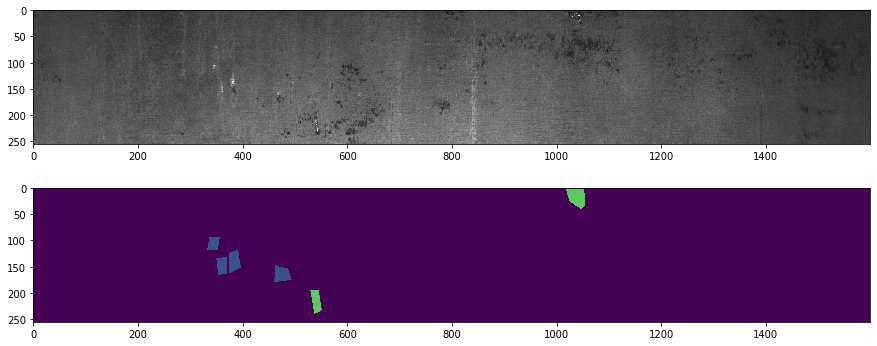

In [14]:
for image_id in image_ids[:2]:
    image = np.array(Image.open(image_id_to_file[image_id]))
    height, width = image.shape[:2]
    
    rle_masks = image_id_to_masks[image_id]
    masks = [image_utils.rle_to_mask(rle_mask, height, width) for rle_mask in rle_masks]
    mask = masks_to_mask(masks)
    
    fig=plt.figure(figsize=(15, 6))
    plt.subplot(2,1,1)
    plt.imshow(image)
    plt.subplot(2,1,2)
    plt.imshow(mask, vmin=0, vmax=4)
    plt.show()

# Label information

In [15]:
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [16]:
class_id_to_masks = defaultdict(list)
for label_id, rle_mask in zip(train_df.ImageId_ClassId, train_df.EncodedPixels):
    class_id = int(label_id.split('_')[-1])
    class_id_to_masks[class_id].append(rle_mask)

In [17]:
for class_id in class_id_to_masks:
    masks = class_id_to_masks[class_id]
    print("Class #{} is in {} slides out of {}".format(
        class_id, sum([isinstance(m, str) for m in masks]), len(masks)))

Class #1 is in 897 slides out of 12568
Class #2 is in 247 slides out of 12568
Class #3 is in 5150 slides out of 12568
Class #4 is in 801 slides out of 12568


# Visualize samples

In [21]:
def plot_image_and_label(image, label):
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.subplot(2, 1, 2)
    plt.imshow(label, vmin=0, vmax=4)
    plt.show()

7c27585fd


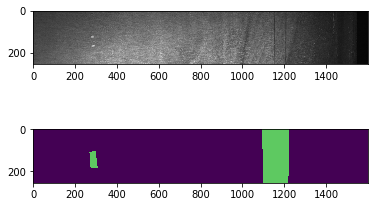

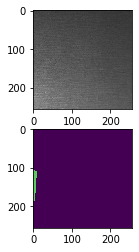

689c12926
876e74fd6
9e467cb05


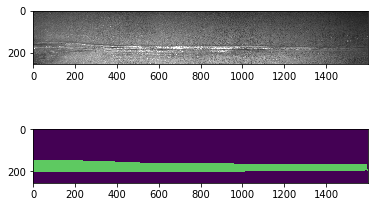

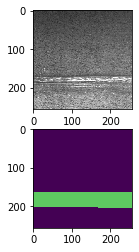

7486d3e78


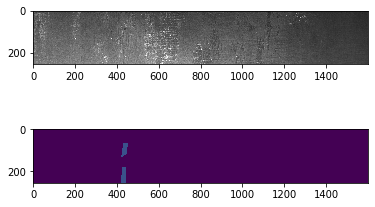

4cf3b3988


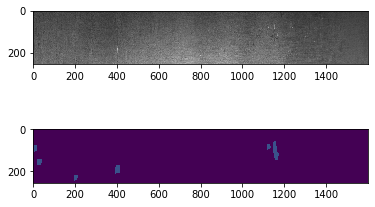

af0aad614


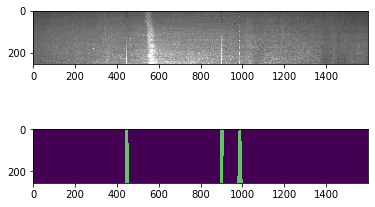

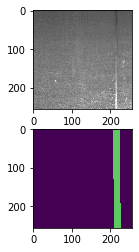

51632c4a4


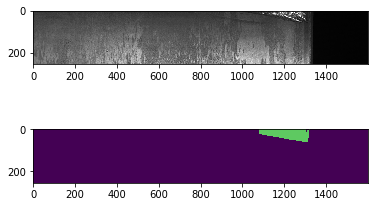

b7fd1f63b


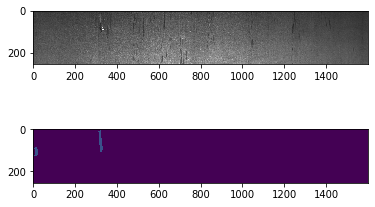

194244a20
108ea689b


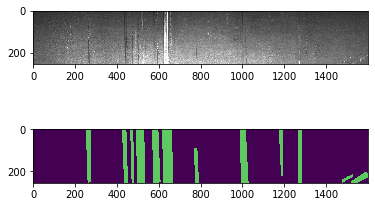

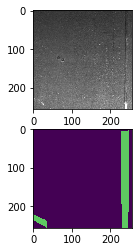

179b27647


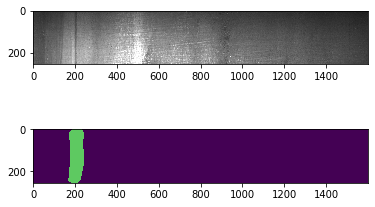

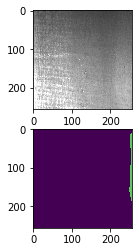

db3d85bc9


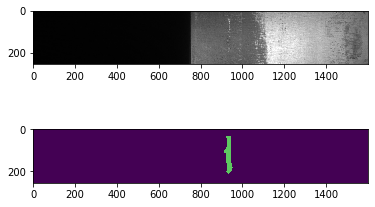

In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)
count = 0
n_plots = 10

while count < n_plots:
    image_id = np.random.choice(image_ids)
    print(image_id)
    
    # Load image and mask
    image = np.array(Image.open(image_id_to_file[image_id]))
    height, width = image.shape[:2]
    rle_masks = image_id_to_masks[image_id]
    masks = [image_utils.rle_to_mask(rle_mask, height, width) for rle_mask in rle_masks]
    mask = masks_to_mask(masks)
    if np.max(mask) == 0:
        continue
    plot_image_and_label(image, mask)
        
    mask = np.expand_dims(mask, -1)
    original_image, sample_image, sample_label = input_preprocess.preprocess_image_and_label(image, mask, 256, 256)

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        sample_image, sample_label = sess.run([sample_image, sample_label])
        sample_image /= 255
        sample_label = sample_label[:, :, 0]
    
    if np.max(sample_label) == 0:
        continue
    
    plot_image_and_label(sample_image, sample_label)
    count += 1